## Import libraries

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
# read the dataset
train_df = pd.read_csv('data/train_final.csv')


In [4]:
train_df.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,...,oil_price,transactions,is_holiday,week,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
0,24,96995,2013-01-09,2.0,0,2013,1,9,2,0.285714,...,93.08,2354.0,0,2,0,0.0,0.0,0.0,0.000000,0.000000
1,24,96995,2013-01-10,0.0,0,2013,1,10,3,0.285714,...,93.81,2226.0,0,2,0,2.0,0.0,0.0,0.285714,0.755929
2,24,96995,2013-01-11,0.0,0,2013,1,11,4,0.285714,...,93.60,2350.0,0,2,0,0.0,0.0,0.0,0.285714,0.755929
3,24,96995,2013-01-12,2.0,0,2013,1,12,5,0.571429,...,93.60,2346.0,1,2,1,0.0,0.0,0.0,0.285714,0.755929
4,24,96995,2013-01-13,0.0,0,2013,1,13,6,0.571429,...,93.60,2001.0,0,2,1,2.0,0.0,0.0,0.571429,0.975900


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9396176 entries, 0 to 9396175
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   date               object 
 3   unit_sales         float64
 4   onpromotion        int64  
 5   year               int64  
 6   month              int64  
 7   day                int64  
 8   day_of_week        int64  
 9   unit_sales_7d_avg  float64
 10  perishable         int64  
 11  oil_price          float64
 12  transactions       float64
 13  is_holiday         int64  
 14  week               int64  
 15  is_weekend         int64  
 16  lag_1              float64
 17  lag_7              float64
 18  lag_30             float64
 19  rolling_mean_7     float64
 20  rolling_std_7      float64
dtypes: float64(9), int64(11), object(1)
memory usage: 1.5+ GB


### Time-Based Train/Test Split

In [6]:
# Make sure 'date' is datetime
train_df['date'] = pd.to_datetime(train_df['date'])
split_date = '2014-01-01'
train = train_df[train_df['date'] < split_date]
test = train_df[train_df['date'] > split_date]

### Feature & Target Separation

In [7]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']


### XGBoost Model

In [8]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### test the model

In [9]:
# Predict on test set
y_pred = xgboost_model.predict(X_test)


### Evaluate the model Numerically

In [10]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.8547882339767793
MAE: 0.8015753926840683


##### We can plot the differences between predicted and actual values

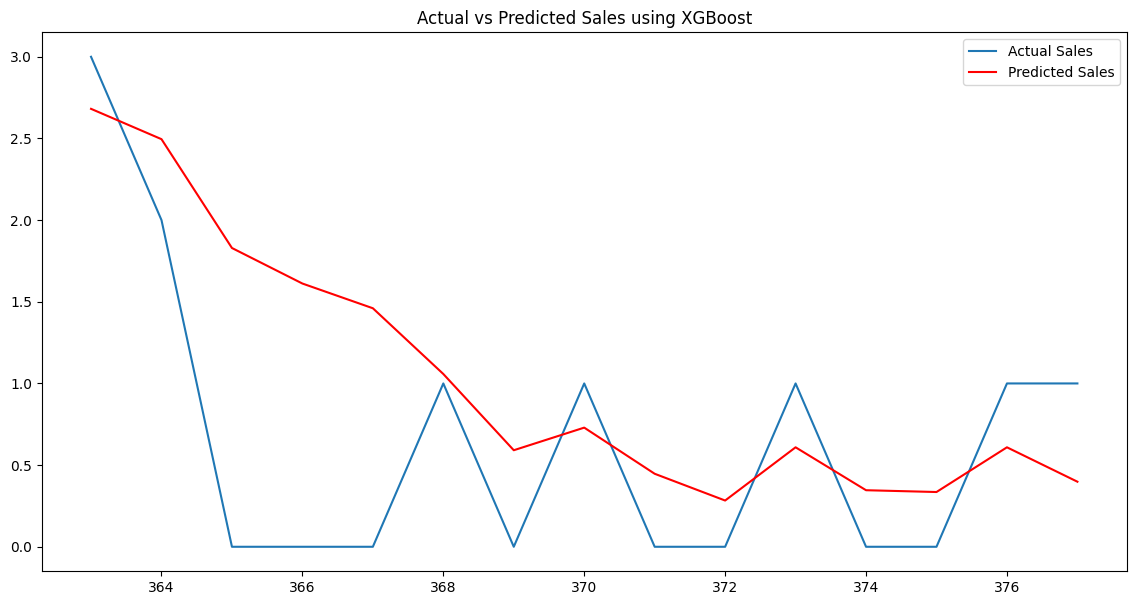

In [11]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

##### This is our baseline model. Now will do some inprovements.

### Hyperparameter Tuning

In [12]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 1.0}


#### Now we can get the Best Model

In [13]:
best_model = random_search.best_estimator_

#### Calculate the values for the testing portion of Data

In [14]:
# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

#### Evaluation Metrics

In [15]:
# Metrics
print("R2:", r2_score(y_true=y_test, y_pred=y_pred_best))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred_best))

R2: 0.8379728522032384
MAE: 0.6095020575504577


#### Plot the Predictions Visually

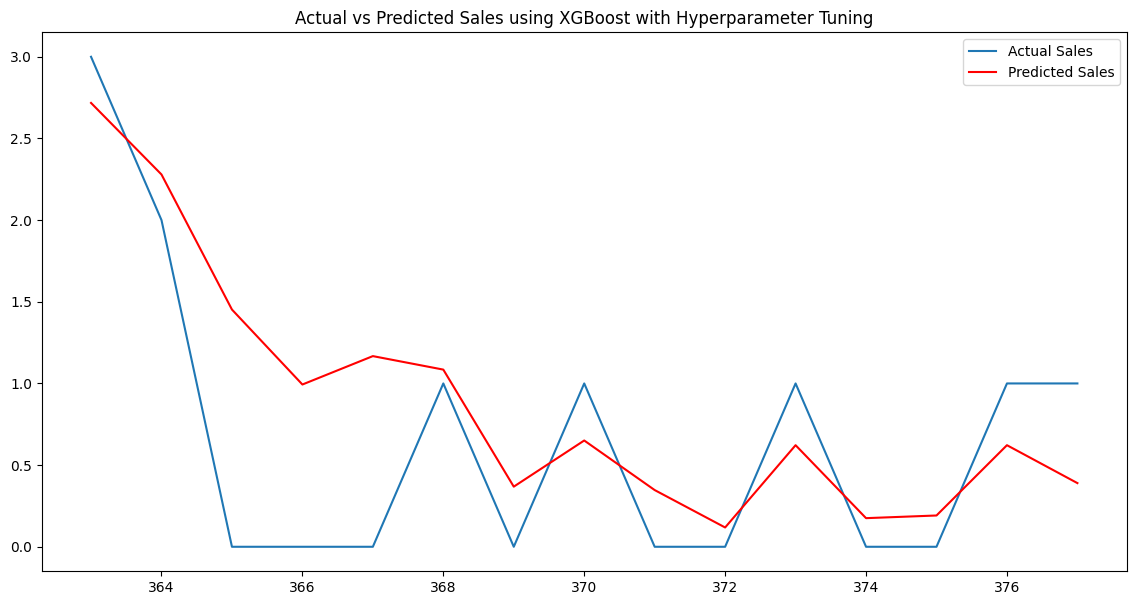

In [16]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred_best[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost with Hyperparameter Tuning')
plt.legend()
plt.show()

##### Not perfect but a litter better than before!

##### Save XGBoost Model Locally with Pickle

In [21]:
import pickle
import os

# ✅ Create a folder to store the model
folder_path = './saved_models'
os.makedirs(folder_path, exist_ok=True)

# ✅ Define full path with filename
pickle_path = os.path.join(folder_path, 'best_model.pkl')

# ✅ Save the model
with open(pickle_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f" Model saved as pickle file at: {pickle_path}")



 Model saved as pickle file at: ./saved_models/best_model.pkl


##### To Load the Model Later

In [ ]:
# Load the XGBoost model
with open(pickle_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Use it to predict
y_pred = loaded_model.predict(X_test)


In [23]:
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

R2: 0.8379728522032384
MAE: 0.6095020575504577


#### LSTM model

In [65]:
# LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [66]:
# Create scalers for X and y
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [67]:
# Scale inputs
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Scale outputs
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

##### Reshape for LSTM
LSTM expects input of shape (samples, timesteps, features). We assume 1 timestep here (you can change this later if you want sequence modeling).

In [32]:
# Reshape to 3D for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


##### Define and Train the LSTM Model

In [33]:
# Define model
model = Sequential()
model.add(LSTM(32, input_shape=(1, X_train.shape[1])))  # (timesteps, features)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train_lstm, y_train_scaled, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 471us/step - loss: 5.2004e-06
Epoch 2/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 477us/step - loss: 5.9383e-07
Epoch 3/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 474us/step - loss: 5.3665e-07
Epoch 4/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 475us/step - loss: 4.8560e-07
Epoch 5/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 473us/step - loss: 4.3869e-07
Epoch 6/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 472us/step - loss: 4.4785e-07
Epoch 7/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 476us/step - loss: 3.8662e-07
Epoch 8/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 475us/step - loss: 3.9648e-07
Epoch 9/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 476us/step - loss: 3.9214e-07
Epoch 10/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 477us/step - loss: 3.7516e-07
Epoch 11/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 478us/step - loss: 3.5686e-07
Epoch 12/20
117583/117583 ━━━━━━━━━━━━━━━━━━━━ 56s 475us/step - loss: 3.6824e-07
Epoch 13/20
117583/117583 ━━━━━━━━━━━

#####  Make Predictions and Inverse Scale

In [34]:
# Predict
y_pred_scaled = model.predict(X_test_lstm)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Convert y_test back to original scale for comparison
y_test_actual = y_scaler.inverse_transform(y_test_scaled)


57817/57817 ━━━━━━━━━━━━━━━━━━━━ 14s 237us/step


##### Evaluate Performance

In [ ]:
# Evaluate Metrics
print("LSTM R2:", r2_score(y_true=y_test_actual, y_pred=y_pred))
print("LSTM MAE:", mean_absolute_error(y_true=y_test_actual, y_pred=y_pred))


LSTM R2: -6.389726537548201
LSTM MAE: 22.373548997359553


##### Plot Predictions

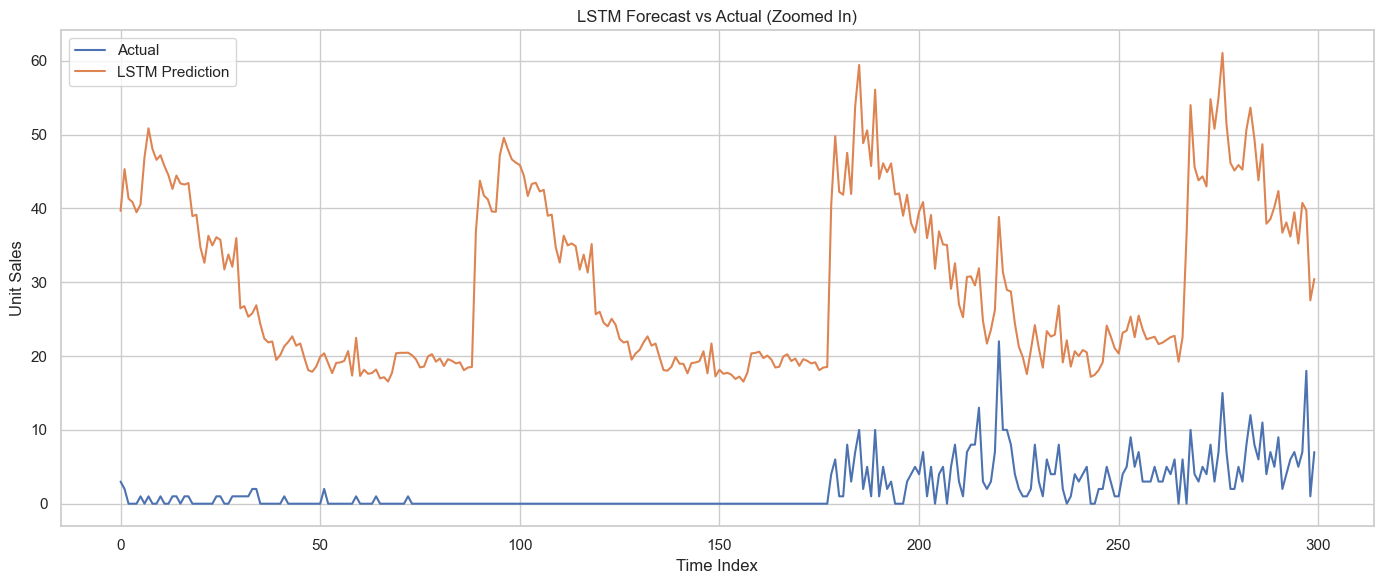

In [44]:
# Zoom into a slice (e.g., first 300 points)
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual[:300], label='Actual')
plt.plot(y_pred[:300], label='LSTM Prediction')
plt.title('LSTM Forecast vs Actual (Zoomed In)')
plt.xlabel('Time Index')
plt.ylabel('Unit Sales')
plt.legend()
plt.tight_layout()
plt.show()
